In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed
import multiprocessing
import os
import warnings
import joblib
warnings.filterwarnings('ignore')

In [ ]:
# Create directory for saving plots
os.makedirs('plots', exist_ok=True)

In [ ]:
# Set plot style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# 1. Data Loading & Overview

In [ ]:
# Load the dataset
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/My Drive/nepal-earthquake-severity-index-latest.csv'
df = pd.read_csv(file_path)

In [ ]:
# Drop rows with all NaN values
df = df.dropna(how='all')

In [ ]:
# Display dataset information
print(f"\nDataset Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")



Dataset Shape: (3985, 12)
Columns: ['P_CODE', 'VDC_NAME', 'DISTRICT', 'REGION', 'Hazard (Intensity)', 'Exposure', 'Housing', 'Poverty', 'Vulnerability', 'Severity', 'Severity Normalized', 'Severity category']


In [ ]:
# Check for missing values
print("\nMissing Values:")
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])
else:
    print("No missing values found")



Missing Values:
No missing values found


In [ ]:
# Display sample rows
print("\nFirst 5 rows:")
print(df.head())


First 5 rows:
         P_CODE            VDC_NAME   DISTRICT   REGION  Hazard (Intensity)  \
0  C-BAG-27-031       KathmanduN.P.  Kathmandu  Central                2.17   
1  C-BAG-25-027        LalitpurN.P.   Lalitpur  Central                1.72   
2  C-NAR-35-005      BharatpurN. P.   Chitawan  Central                2.21   
3  C-BAG-26-012  MadhyapurThimiN.P.  Bhaktapur  Central                2.45   
4  C-BAG-27-028             Jorpati  Kathmandu  Central                1.91   

   Exposure  Housing  Poverty  Vulnerability  Severity  Severity Normalized  \
0     10.00     8.86     1.82           5.34      4.88              10.0000   
1      2.26     8.40     0.82           4.61      2.62               5.3707   
2      1.47     5.38     2.53           3.96      2.34               4.8083   
3      0.85     8.23     0.89           4.56      2.12               4.3447   
4      0.87     8.86     1.82           5.34      2.07               4.2407   

  Severity category  
0           H

# 2. Exploratory Data Analysis (EDA)


In [ ]:
# Define numerical columns
expected_numerical_cols = ['Hazard (Intensity)', 'Exposure', 'Housing', 'Poverty', 'Vulnerability', 'Severity', 'Severity Normalized']
numerical_cols = [col for col in expected_numerical_cols if col in df.columns]

In [ ]:
# Check for target column
if 'Severity category' not in df.columns:
    print("Warning: 'Severity category' column not found.")
    print(f"Available columns: {df.columns.tolist()}")
    exit(1)

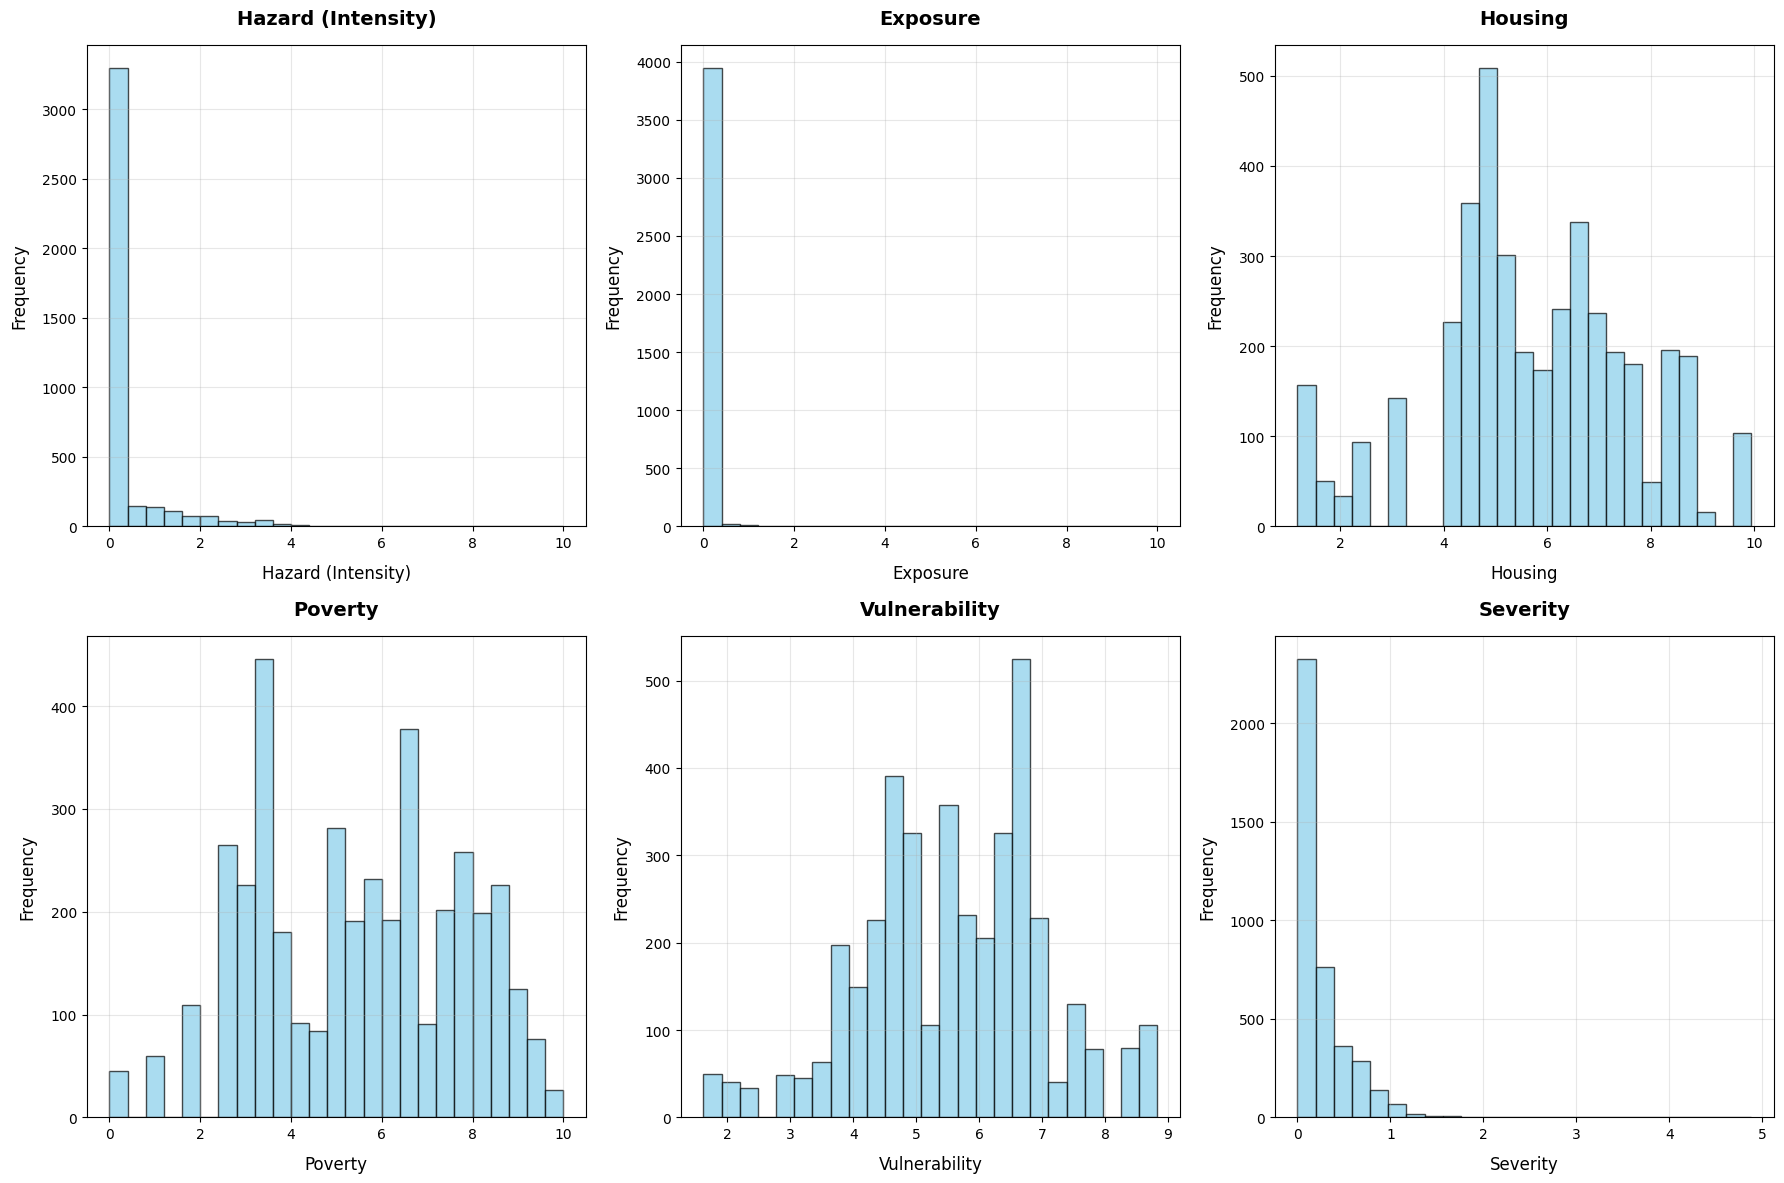

In [ ]:
# Numerical feature distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_cols[:6]):
    if i < len(axes):
        ax = axes[i]
        df[col].hist(bins=25, alpha=0.7, ax=ax, color='skyblue', edgecolor='black')
        ax.set_title(f'{col}', fontweight='bold', pad=15)
        ax.set_xlabel(col, labelpad=10)
        ax.set_ylabel('Frequency', labelpad=10)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 2.2 Class Distribution Analysis - Summary
severity_counts = df['Severity category'].value_counts()
print(f"\nClass Distribution:")
for category, count in severity_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{category}: {count} ({percentage:.1f}%)")



Class Distribution:
Lowest: 1893 (47.5%)
Low: 800 (20.1%)
Medium-Low: 672 (16.9%)
Medium-High: 433 (10.9%)
High: 168 (4.2%)
Highest: 19 (0.5%)


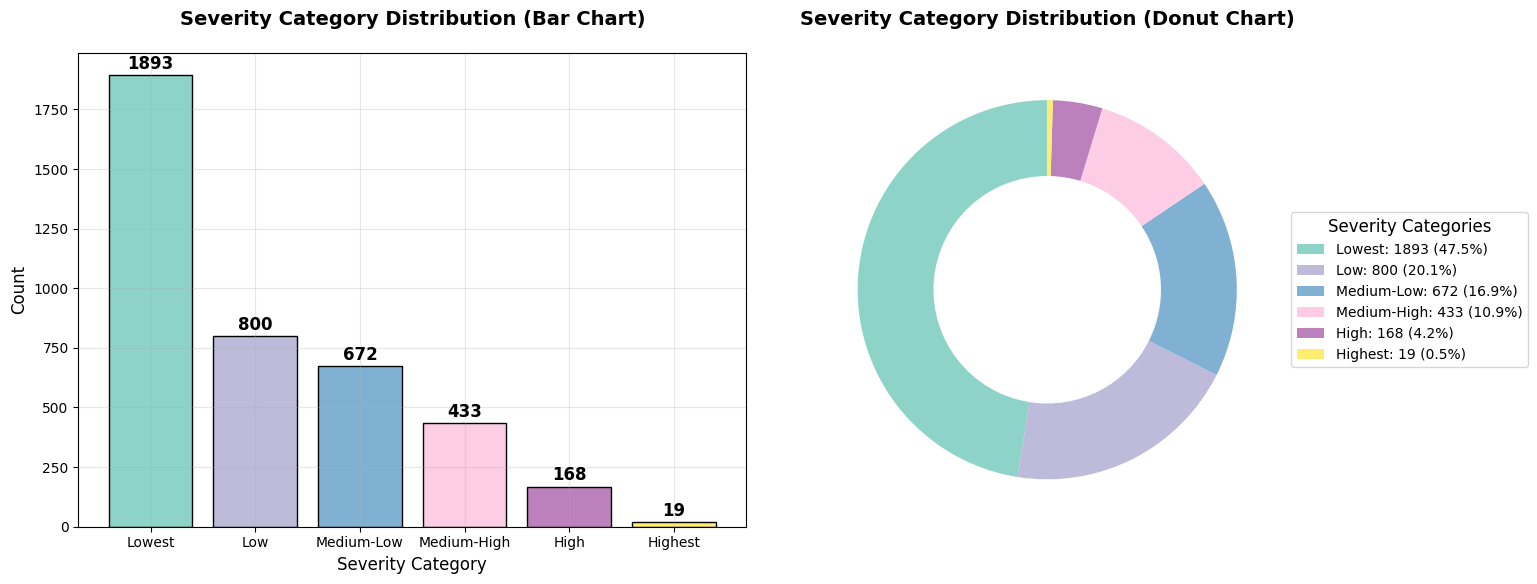

In [ ]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
colors = plt.cm.Set3(np.linspace(0, 1, len(severity_counts)))

# Bar Chart
bars = ax1.bar(severity_counts.index, severity_counts.values, color=colors, edgecolor='black')
ax1.set_title('Severity Category Distribution (Bar Chart)', fontweight='bold', pad=20)
ax1.set_xlabel('Severity Category')
ax1.set_ylabel('Count')
ax1.grid(True, alpha=0.3)

for bar, count in zip(bars, severity_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             str(count), ha='center', va='bottom', fontweight='bold')

# Donut Chart
wedges, _ = ax2.pie(severity_counts.values,
                    startangle=90,
                    colors=colors,
                    wedgeprops=dict(width=0.4))

ax2.set_title('Severity Category Distribution (Donut Chart)', fontweight='bold', pad=20)


legend_labels = [f"{cat}: {count} ({(count/len(df))*100:.1f}%)"
                 for cat, count in zip(severity_counts.index, severity_counts.values)]
ax2.legend(wedges, legend_labels, title="Severity Categories", loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('plots/severity_category_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

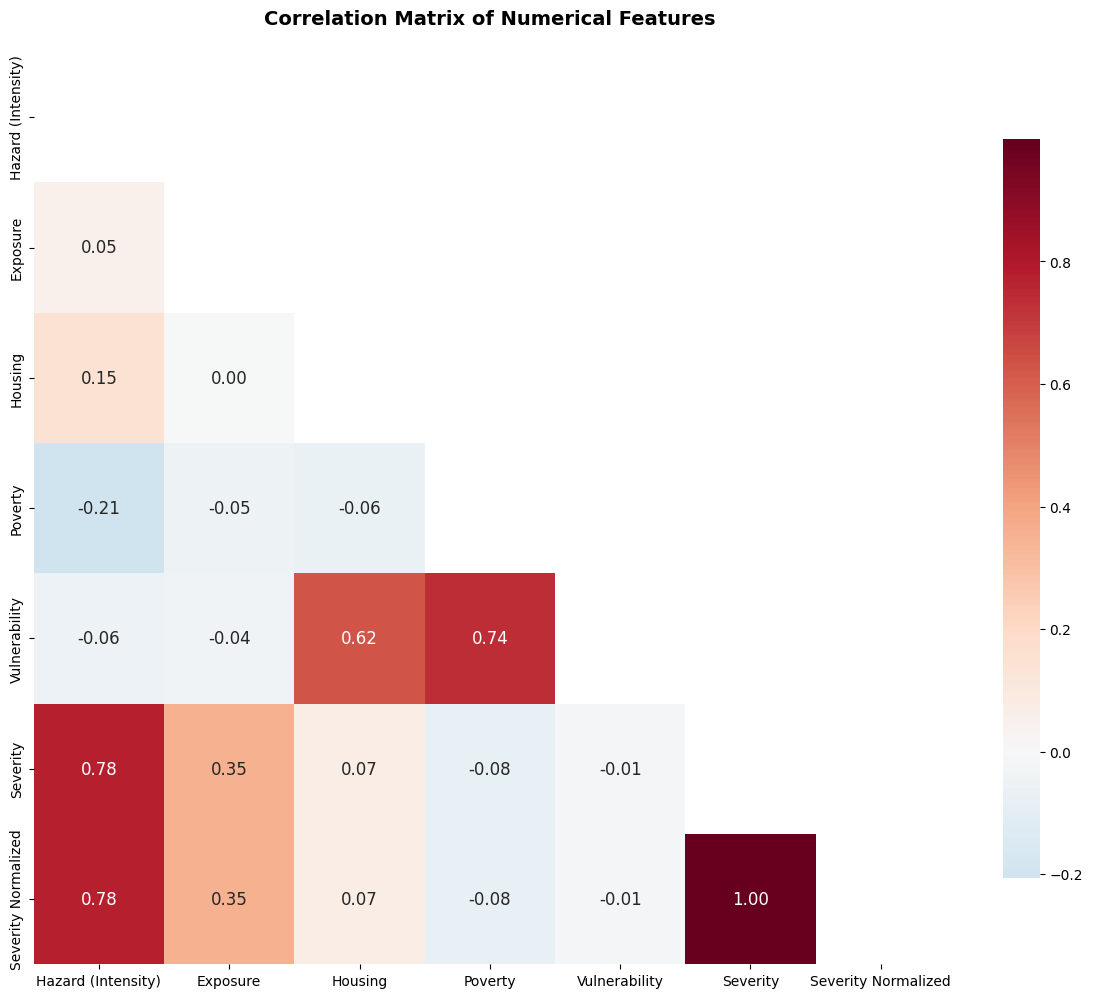

In [ ]:
# 2.3 Correlation Analysis
plt.figure(figsize=(12, 10))
numeric_df = df[numerical_cols].select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix of Numerical Features', fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('plots/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

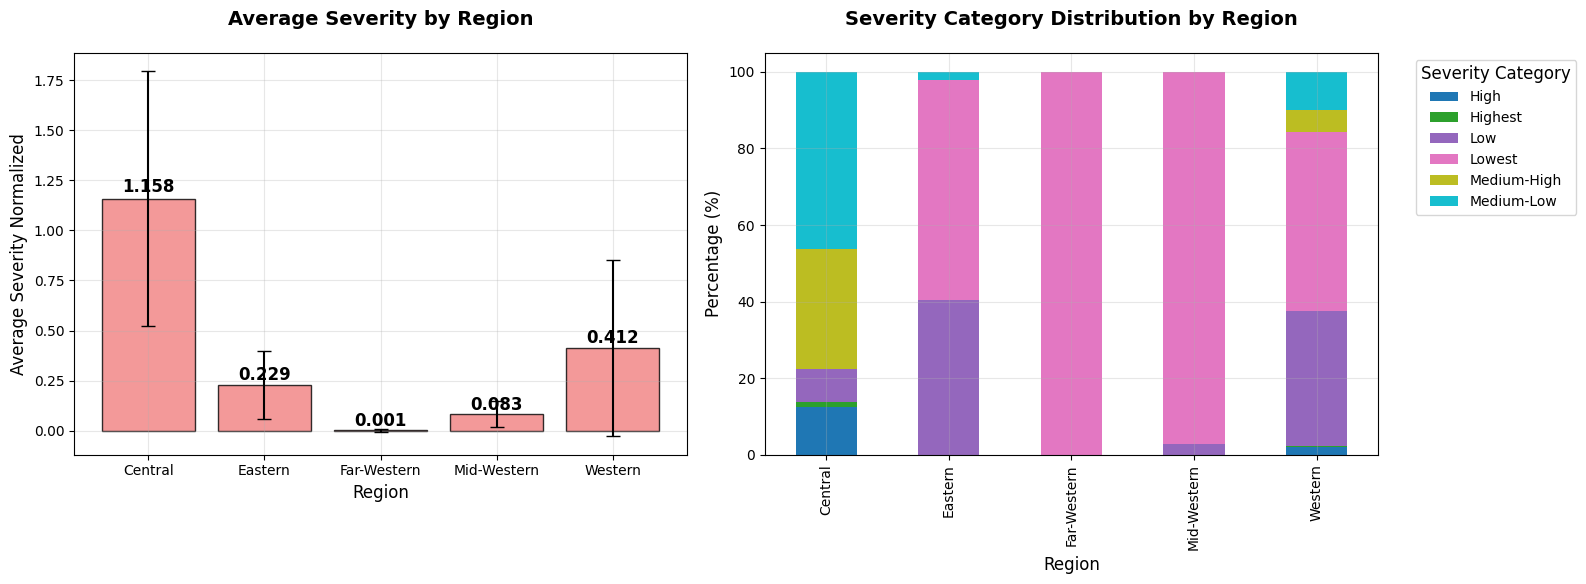

In [ ]:
# 2.4 Regional Analysis
if 'REGION' in df.columns:
    severity_col = 'Severity Normalized' if 'Severity Normalized' in df.columns else 'Severity'

    region_severity = df.groupby('REGION').agg({
        severity_col: ['mean', 'std', 'count']
    }).round(3)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    means = df.groupby('REGION')[severity_col].mean()
    stds = df.groupby('REGION')[severity_col].std()

    bars = ax1.bar(means.index, means.values, yerr=stds.values,
                   capsize=5, alpha=0.8, color='lightcoral', edgecolor='black')
    ax1.set_title('Average Severity by Region', fontweight='bold', pad=20)
    ax1.set_xlabel('Region')
    ax1.set_ylabel(f'Average {severity_col}')
    ax1.grid(True, alpha=0.3)

    for bar, mean_val in zip(bars, means.values):
        ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1.01,
                 f'{mean_val:.3f}', ha='center', va='bottom', fontweight='bold')

    if 'Severity category' in df.columns:
        region_counts = df.groupby(['REGION', 'Severity category']).size().unstack(fill_value=0)
        region_percentages = region_counts.div(region_counts.sum(axis=1), axis=0) * 100

        region_percentages.plot(kind='bar', stacked=True, ax=ax2, colormap='tab10')
        ax2.set_title('Severity Category Distribution by Region', fontweight='bold', pad=20)
        ax2.set_xlabel('Region')
        ax2.set_ylabel('Percentage (%)')
        ax2.legend(title='Severity Category', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, "'Severity category' column missing",
                 ha='center', va='center', fontsize=12)
        ax2.axis('off')

    plt.tight_layout()
    plt.savefig('plots/region_severity_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


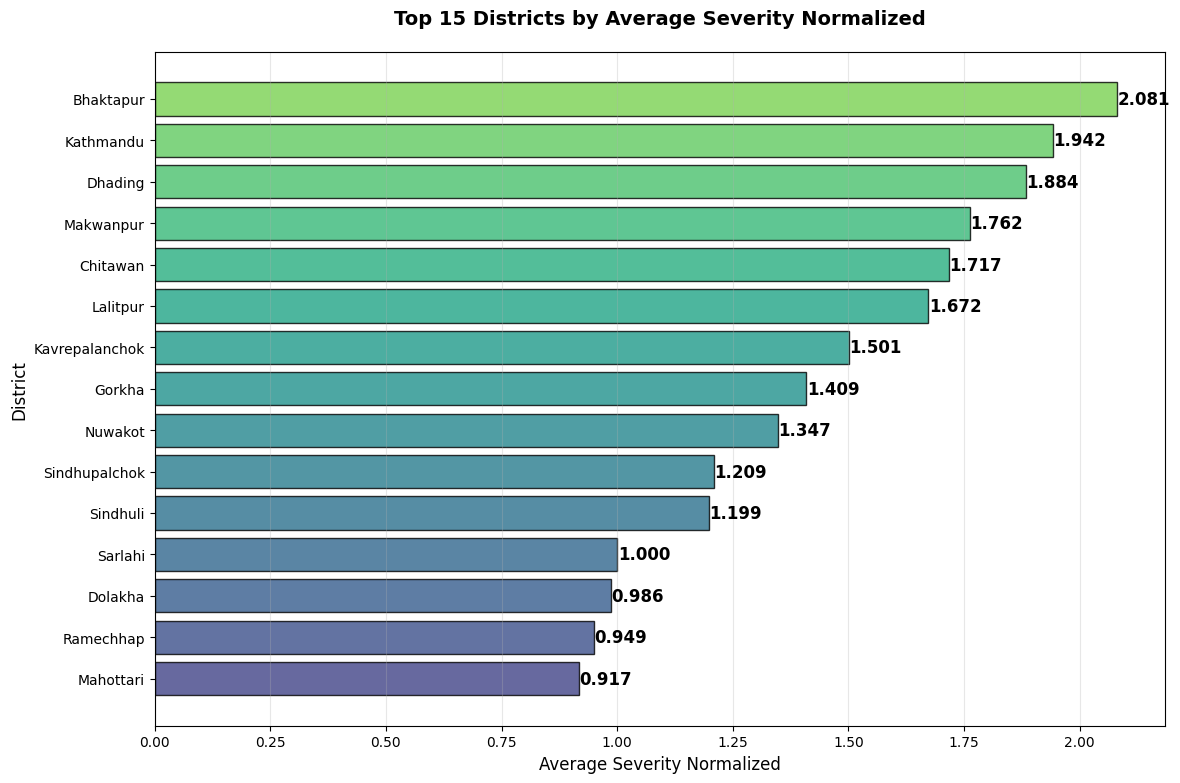

In [ ]:
# 2.5 District Analysis
if 'DISTRICT' in df.columns:
    severity_col = 'Severity Normalized' if 'Severity Normalized' in df.columns else 'Severity'
    district_severity = df.groupby('DISTRICT')[severity_col].mean().sort_values(ascending=True).tail(15)

    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(district_severity)), district_severity.values,
                    color=plt.cm.viridis(np.linspace(0.2, 0.8, len(district_severity))), alpha=0.8, edgecolor='black')
    plt.yticks(range(len(district_severity)), district_severity.index)
    plt.title(f'Top 15 Districts by Average {severity_col}', fontweight='bold', pad=20)
    plt.xlabel(f'Average {severity_col}')
    plt.ylabel('District')
    plt.grid(True, alpha=0.3, axis='x')

    for i, (bar, val) in enumerate(zip(bars, district_severity.values)):
        plt.text(val + 0.001, i, f'{val:.3f}', va='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig('plots/top_districts_severity.png', dpi=300, bbox_inches='tight')
    plt.show()

# 3. Data Preprocessing

In [ ]:
def scale_column(column):
    scaler = StandardScaler()
    return scaler.fit_transform(column.values.reshape(-1, 1)).ravel()

features_for_model = [col for col in numerical_cols if col not in ['Severity', 'Severity Normalized']]

In [ ]:
# 3.1 Serial Preprocessing
start_time = time.time()
X_numerical_serial = df[features_for_model].copy()
for col in features_for_model:
    X_numerical_serial[col] = scale_column(df[col])
preprocessing_time_serial = time.time() - start_time

In [ ]:
# 3.2 Parallel Preprocessing
start_time = time.time()
if len(features_for_model) > 2:
    scaled_features = Parallel(n_jobs=-1)(
        delayed(scale_column)(df[col]) for col in features_for_model
    )
    X_numerical = pd.DataFrame(
        np.column_stack(scaled_features),
        index=df.index,
        columns=features_for_model
    )
else:
    X_numerical = X_numerical_serial.copy()
preprocessing_time_parallel = time.time() - start_time



In [ ]:
print(f"Preprocessing Time (Serial): {preprocessing_time_serial:.4f} seconds")
print(f"Preprocessing Time (Parallel): {preprocessing_time_parallel:.4f} seconds")

Preprocessing Time (Serial): 0.0112 seconds
Preprocessing Time (Parallel): 0.0219 seconds


In [ ]:
# 3.3 Target Encoding
label_encoder = LabelEncoder()
df['Severity category encoded'] = label_encoder.fit_transform(df['Severity category'])
print(f"Target variable encoded. Classes: {label_encoder.classes_}")

Target variable encoded. Classes: ['High' 'Highest' 'Low' 'Lowest' 'Medium-High' 'Medium-Low']


In [ ]:
# 3.4 Handle Class Imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(df['Severity category encoded']),
                                   y=df['Severity category encoded'])
class_weight_dict = dict(zip(np.unique(df['Severity category encoded']), class_weights))
print(f"Class weights for balancing: {class_weight_dict}")


Class weights for balancing: {np.int64(0): np.float64(3.953373015873016), np.int64(1): np.float64(34.95614035087719), np.int64(2): np.float64(0.8302083333333333), np.int64(3): np.float64(0.35085402359570345), np.int64(4): np.float64(1.5338722093918398), np.int64(5): np.float64(0.988343253968254)}


In [ ]:
# 3.5 Categorical Encoding
categorical_cols = [col for col in ['REGION', 'DISTRICT'] if col in df.columns]
if categorical_cols:
    onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_cats = onehot_encoder.fit_transform(df[categorical_cols])
    encoded_cats_df = pd.DataFrame(encoded_cats, columns=onehot_encoder.get_feature_names_out(categorical_cols))
    print(f"Categorical variables encoded: {categorical_cols}")
else:
    encoded_cats_df = pd.DataFrame(index=df.index)


Categorical variables encoded: ['REGION', 'DISTRICT']


In [ ]:
# 3.6 Feature Matrix Creation
X = pd.concat([X_numerical, encoded_cats_df], axis=1)
y = df['Severity category encoded']

print(f"Final feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Final feature matrix shape: (3985, 85)
Target vector shape: (3985,)


In [ ]:
# 3.7 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Train set shape: (3188, 85)
Test set shape: (797, 85)


# 4. Model Training & Evaluation

In [ ]:
print("Training Serial Model (n_jobs=1)...")
model_serial = RandomForestClassifier(
    random_state=42,
    n_jobs=1,
    n_estimators=100,
    class_weight=class_weight_dict
)
start_time = time.time()
model_serial.fit(X_train, y_train)
training_time_serial = time.time() - start_time

y_pred_serial = model_serial.predict(X_test)
accuracy_serial = accuracy_score(y_test, y_pred_serial)
print(f"Serial model training time: {training_time_serial:.4f} seconds")
print(f"Serial model accuracy: {accuracy_serial:.4f}")

Training Serial Model (n_jobs=1)...
Serial model training time: 0.9709 seconds
Serial model accuracy: 0.9360


In [ ]:
# 4.2 Parallel Model Training
print("\nTraining Parallel Model (n_jobs=-1)...")
model_parallel = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    n_estimators=100,
    class_weight=class_weight_dict
)
start_time = time.time()
model_parallel.fit(X_train, y_train)
training_time_parallel = time.time() - start_time

y_pred_parallel = model_parallel.predict(X_test)
accuracy_parallel = accuracy_score(y_test, y_pred_parallel)
print(f"Parallel model training time: {training_time_parallel:.4f} seconds")
print(f"Parallel model accuracy: {accuracy_parallel:.4f}")



Training Parallel Model (n_jobs=-1)...
Parallel model training time: 0.9893 seconds
Parallel model accuracy: 0.9360


In [ ]:
# 4.3 Stratified Cross-Validation
print("\nPerforming Stratified Cross-Validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_parallel, X, y, cv=skf, scoring='accuracy', n_jobs=-1)
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
model_parallel = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    n_estimators=100,
    class_weight=class_weight_dict
)
start_time = time.time()
model_parallel.fit(X_train, y_train)
training_time_parallel = time.time() - start_time

y_pred_parallel = model_parallel.predict(X_test)
accuracy_parallel = accuracy_score(y_test, y_pred_parallel)
print(f"Parallel model training time: {training_time_parallel:.4f} seconds")
print(f"Parallel model accuracy: {accuracy_parallel:.4f}")



Performing Stratified Cross-Validation...
Cross-Validation Accuracy: 0.9338 ± 0.0071
Parallel model training time: 0.4504 seconds
Parallel model accuracy: 0.9360


In [ ]:
# Stratified cross-validation to reduce variance
print("\nPerforming Stratified Cross-Validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_parallel, X, y, cv=skf, scoring='accuracy', n_jobs=-1)
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")



Performing Stratified Cross-Validation...
Cross-Validation Accuracy: 0.9338 ± 0.0071


In [ ]:
from sklearn.metrics import classification_report

print("\nClassification Report (Serial Model):")
print(classification_report(y_test, y_pred_serial, target_names=label_encoder.classes_))

print("\nClassification Report (Parallel Model):")
print(classification_report(y_test, y_pred_parallel, target_names=label_encoder.classes_))



Classification Report (Serial Model):
              precision    recall  f1-score   support

        High       0.83      0.85      0.84        34
     Highest       1.00      0.50      0.67         4
         Low       0.93      0.91      0.92       160
      Lowest       0.98      0.98      0.98       379
 Medium-High       0.89      0.84      0.86        86
  Medium-Low       0.88      0.94      0.91       134

    accuracy                           0.94       797
   macro avg       0.92      0.84      0.86       797
weighted avg       0.94      0.94      0.94       797


Classification Report (Parallel Model):
              precision    recall  f1-score   support

        High       0.83      0.85      0.84        34
     Highest       1.00      0.50      0.67         4
         Low       0.93      0.91      0.92       160
      Lowest       0.98      0.98      0.98       379
 Medium-High       0.89      0.84      0.86        86
  Medium-Low       0.88      0.94      0.91       13

# 5. Performance Comparison


In [ ]:
speedup = training_time_serial / training_time_parallel
print(f"Training Speedup: {speedup:.2f}x")
print(f"CPU Cores Available: {multiprocessing.cpu_count()}")

Training Speedup: 2.16x
CPU Cores Available: 2


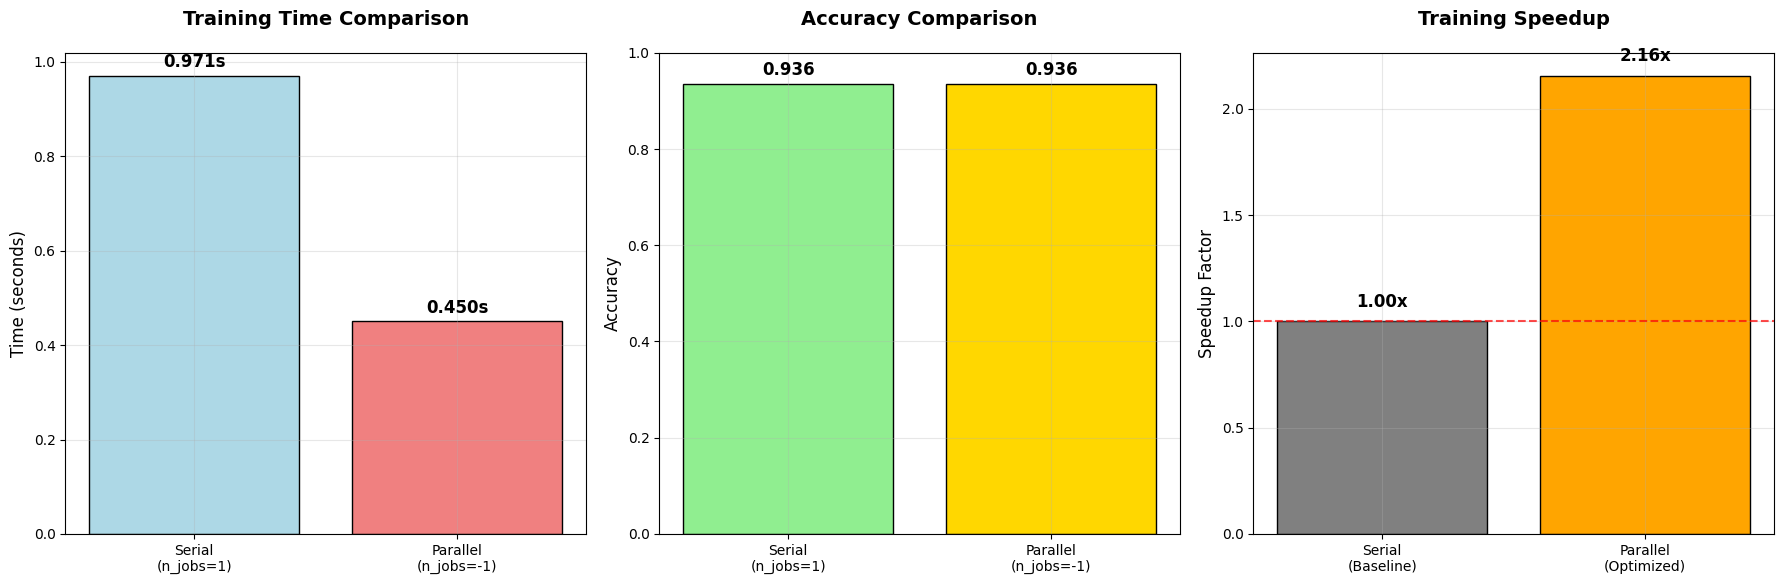

In [ ]:
# Performance comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Training time comparison
methods = ['Serial\n(n_jobs=1)', 'Parallel\n(n_jobs=-1)']
training_times = [training_time_serial, training_time_parallel]
colors = ['lightblue', 'lightcoral']

bars1 = axes[0].bar(methods, training_times, color=colors, edgecolor='black')
axes[0].set_title('Training Time Comparison', fontweight='bold', pad=20)
axes[0].set_ylabel('Time (seconds)')
axes[0].grid(True, alpha=0.3)

for bar, time in zip(bars1, training_times):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{time:.3f}s', ha='center', va='bottom', fontweight='bold')

# Accuracy comparison
accuracies = [accuracy_serial, accuracy_parallel]
bars2 = axes[1].bar(methods, accuracies, color=['lightgreen', 'gold'], edgecolor='black')
axes[1].set_title('Accuracy Comparison', fontweight='bold', pad=20)
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3)

for bar, acc in zip(bars2, accuracies):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Speedup visualization
speedup_data = ['Serial\n(Baseline)', 'Parallel\n(Optimized)']
speedup_values = [1.0, speedup]
bars3 = axes[2].bar(speedup_data, speedup_values, color=['gray', 'orange'], edgecolor='black')
axes[2].set_title('Training Speedup', fontweight='bold', pad=20)
axes[2].set_ylabel('Speedup Factor')
axes[2].axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Baseline')
axes[2].grid(True, alpha=0.3)

for bar, speed in zip(bars3, speedup_values):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                f'{speed:.2f}x', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('plots/performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# 6. Results Visualization

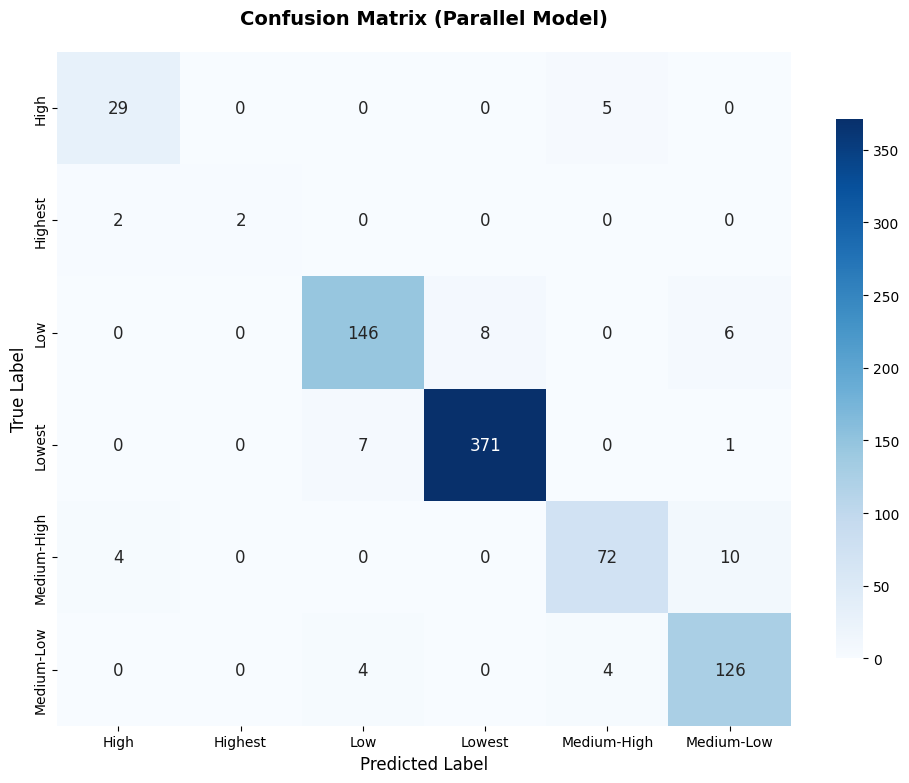

In [ ]:
# Cconfusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_parallel)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'shrink': 0.8})
plt.title('Confusion Matrix (Parallel Model)', fontweight='bold', pad=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('plots/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Feature importance analysis
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model_parallel.feature_importances_
}).sort_values(by='Importance', ascending=True)


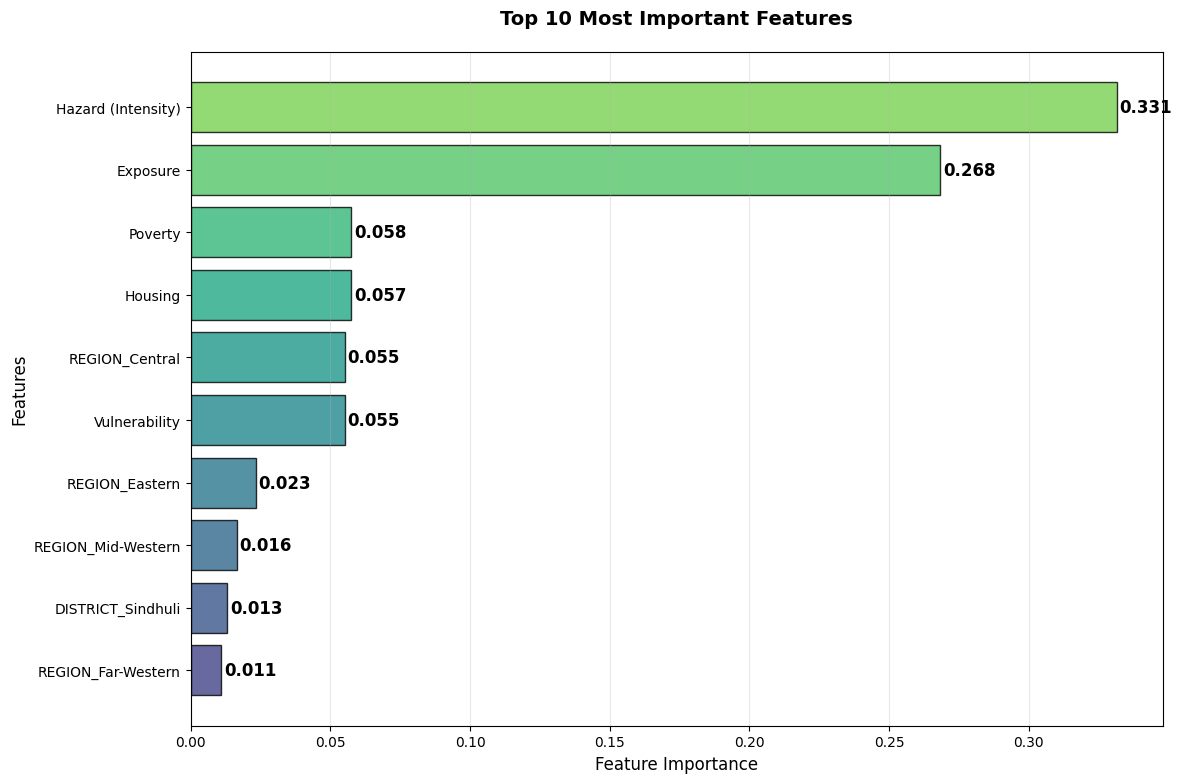

In [ ]:
# Top 10 features
top_features = importance_df.tail(10)

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(top_features)), top_features['Importance'],
                color=plt.cm.viridis(np.linspace(0.2, 0.8, len(top_features))), alpha=0.8, edgecolor='black')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.title('Top 10 Most Important Features', fontweight='bold', pad=20)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.grid(True, alpha=0.3, axis='x')

for i, (bar, val) in enumerate(zip(bars, top_features['Importance'])):
    plt.text(val + 0.001, i, f'{val:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('plots/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 7. Model Saving

In [ ]:
# Save the best model
joblib.dump(model_parallel, 'earthquake_severity_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
print("Model saved as 'earthquake_severity_model.pkl'")
print("Label encoder saved as 'label_encoder.pkl'")


Model saved as 'earthquake_severity_model.pkl'
Label encoder saved as 'label_encoder.pkl'


# 8. Final Results Summary

In [ ]:
print("TIMING ANALYSIS:")
print(f"  Preprocessing (Serial): {preprocessing_time_serial:.4f} seconds")
print(f"  Preprocessing (Parallel): {preprocessing_time_parallel:.4f} seconds")
print(f"  Training (Serial): {training_time_serial:.4f} seconds")
print(f"  Training (Parallel): {training_time_parallel:.4f} seconds")
print(f"  Training Speedup: {speedup:.2f}x")

TIMING ANALYSIS:
  Preprocessing (Serial): 0.0112 seconds
  Preprocessing (Parallel): 0.0219 seconds
  Training (Serial): 0.9709 seconds
  Training (Parallel): 0.4504 seconds
  Training Speedup: 2.16x


In [ ]:
print(f"\nMODEL PERFORMANCE:")
print(f"  Test Accuracy: {accuracy_parallel:.4f}")
print(f"  Cross-Validation: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


MODEL PERFORMANCE:
  Test Accuracy: 0.9360
  Cross-Validation: 0.9338 ± 0.0071


In [ ]:
print(f"\nCLASS DISTRIBUTION:")
for i, class_name in enumerate(label_encoder.classes_):
    count = np.sum(y_test == i)
    print(f"  {class_name}: {count} samples")



CLASS DISTRIBUTION:
  High: 34 samples
  Highest: 4 samples
  Low: 160 samples
  Lowest: 379 samples
  Medium-High: 86 samples
  Medium-Low: 134 samples


In [ ]:
print(f"\nTOP 3 IMPORTANT FEATURES:")
top_3_features = importance_df.tail(3)
for idx, row in top_3_features.iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.4f}")


TOP 3 IMPORTANT FEATURES:
  Poverty: 0.0575
  Exposure: 0.2683
  Hazard (Intensity): 0.3315


In [ ]:
df.to_csv('/content/drive/My Drive/cleaned_nepal_earthquake_severity.csv', index=False)


In [ ]:
print(f"\nCONCLUSION:")
print(f"  - Parallel processing achieved {speedup:.2f}x speedup in training")
print(f"  - Model achieved {accuracy_parallel:.4f} accuracy with balanced classes")
print(f"  - Cross-validation shows {cv_scores.std():.4f} standard deviation")
print(f"  - All visualizations saved in 'plots/' directory")
print(f"  - Model ready for deployment")



CONCLUSION:
  - Parallel processing achieved 2.16x speedup in training
  - Model achieved 0.9360 accuracy with balanced classes
  - Cross-validation shows 0.0071 standard deviation
  - All visualizations saved in 'plots/' directory
  - Model ready for deployment


In [ ]:
print("\nAnalysis completed successfully!")


Analysis completed successfully!
